In [292]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

sns.set_style("whitegrid")

def make_die(sides=6):
    return pd.Series(np.ones(sides)/sides, index=np.arange(1, sides+1))


def add_dist(*dists):
    """Make an addends distribution."""
    res = {}
    for idxs in product(*[dist.index.values for dist in dists]):
        q = sum(idxs)
        p = 1
        for n, i in enumerate(idxs):
            p *= dists[n].loc[i] 
        
        res[q] = res.get(q, 0) + p

    pmfAdd = pd.Series(res).sort_index()
    return pmfAdd


def mix_dist(*dists, ps=None):
    """Make a mixture of distributions."""
    df = pd.DataFrame(dists).fillna(0)
    
    if ps is None:
        _n = len(dists)
        ps = np.ones(_n) / _n
    
    pmf = pd.DataFrame.mul(df, ps, axis='index').sum(0)
    return pmf


def to_pmf(cdf):
    _cdf = cdf.diff()
    _cdf.fillna(1-_cdf.sum(), inplace=True)
    return _cdf

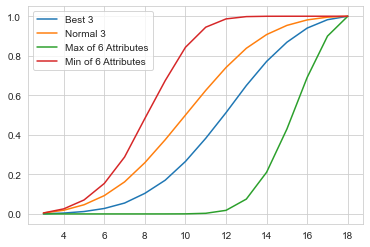

In [146]:
"""
6 attributes, each attribute is determined by throwing 4 independent dice and summing up the best 3
Max and Min of a distribution is easier to calculate using CDF instead of PMF
"""

N, C = 4, 3
sides = 6
die = make_die(sides=sides)
dice = [die] * C
pmfAdd = add_dist(*dice)

pmfBest3 = np.random.choice(die.index.values, size=(10000,N), p=die.values)
pmfBest3.sort(axis=1)
pmfBest3 = pd.Series(pmfBest3[:,1:].sum(1)).value_counts(normalize=True).sort_index()

pmfBest3.cumsum().plot(label='Best 3')
pmfAdd.cumsum().plot(label='Normal 3')
(pmfBest3.cumsum()**6).plot(label='Max of 6 Attributes')
(1-(1-pmfBest3.cumsum())**6).plot(label='Min of 6 Attributes')
plt.legend()

In [156]:
standard = np.array([15,14,13,12,10,8])
mu = (pmfBest3.index.values * pmfBest3.values).sum()
std = ((pmfBest3.index.values - mu) ** 2 * pmfBest3.values).sum() ** (1/2)
print('Mean', mu, standard.mean())
print('Std', std, standard.std())
print('P[X<8] = %.2f%%' % (pmfBest3.loc[:8-1].sum()*100))
# 1 - (1 - P[X<8]) ** 6
print('P[at least 1 out of 6 Xs < 8] = %.2f%%' % ((1 - (1 - pmfBest3.loc[:8-1].sum()) ** 6) * 100))
print('P[X>15] = %.2f%%' % (pmfBest3.loc[15+1:].sum() * 100))
# 1 - (1 - P(X>15)) ** 6
print('P[at least 1 out of 6 Xs > 15] = %.2f%%' % ((1 - (1-pmfBest3.loc[15+1:].sum())**6) * 100))

Mean 12.2533 12.0
Std 2.839144080528496 2.3804761428476167
P[X<8] = 5.50%
P[at least 1 out of 6 Xs < 8] = 28.78%
P[X>15] = 13.14%
P[at least 1 out of 6 Xs > 15] = 57.05%


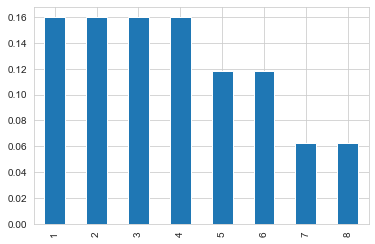

<AxesSubplot:>

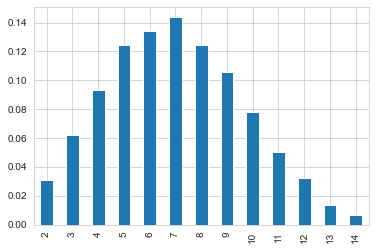

In [77]:
mix1 = [make_die(4)] + [make_die(6)] * 2 + [make_die(8)] * 3
mix1 = mix_dist(*mix1)
mix1.plot(kind='bar')
plt.show()

add_dist(*[mix1, mix2]).plot(kind='bar')

P[6 damage again| D] = 13.63%


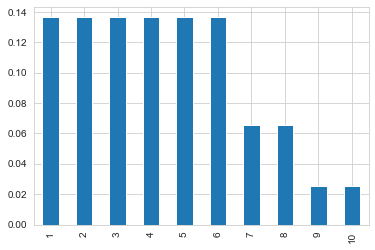

In [206]:
"""
Some mixture distribution tryout
"""
hypos = np.array([6, 8, 10])
prior = np.ones(hypos.size) / hypos.size
likelihood = 1 / hypos
posterior = prior * likelihood
posterior /= posterior.sum()

dice = [make_die(s) for s in hypos]
pmf = mix_dist(*dice, ps=posterior)
pmf.plot(kind='bar')
print('P[6 damage again| D] = %.2f%%' % (pmf.loc[6]*100))

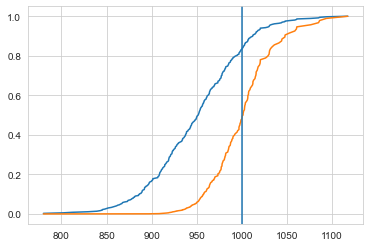

<AxesSubplot:>

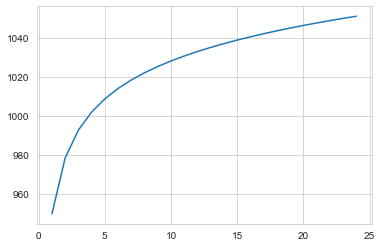

In [303]:
"""
normal bread distribution ~ N(mu=950, sigma=50)
to skew the distribution, how many n bread to heft and give out the max
would shift the distribution to over 1000 mean
"""
np.random.seed(17)
pmf = pd.Series(np.random.normal(loc=950, scale=50, size=365)).value_counts(normalize=True).sort_index()
cdf = pmf.cumsum()
cdf.plot(label='Normal')
(cdf**4).plot(label='Max 4')
plt.axvline(1000)
plt.show()

res = {}
for n in range(1,25):
    _pmf = to_pmf(cdf**n)
    _mu = (_pmf.index.values * _pmf.values).sum()
    res[n] = _mu
res = pd.Series(res).sort_index()
res.plot()